In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import numpy as np

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define data transformations for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define data transformations for validation and test
transform_valid_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
dataset_dir='/content/drive/MyDrive/Datasets/Dataset_2'

# Load the dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(dataset_dir)

# Construct class labels and their corresponding folder paths
class_labels = []
for folder in os.listdir(dataset_dir):
    if os.path.isdir(os.path.join(dataset_dir, folder)):
        for subfolder in os.listdir(os.path.join(dataset_dir, folder)):
            class_labels.append((f"{folder}_{subfolder}", os.path.join(dataset_dir, folder, subfolder)))

# Set the dataset classes and class_to_idx
dataset.classes = [label for label, _ in class_labels]
dataset.class_to_idx = {cls: idx for idx, cls in enumerate(dataset.classes)}

# Print the number of classes and their names
print(f"The number of classes is: {len(dataset.classes)}")
print(f"The classes are: {dataset.classes}")

The number of classes is: 16
The classes are: ['Chinar (P11)_diseased', 'Chinar (P11)_healthy', 'Jamun (P5)_healthy', 'Jamun (P5)_diseased', 'Gauva (P3)_healthy', 'Gauva (P3)_diseased', 'Jatropha (P6)_diseased', 'Jatropha (P6)_healthy', 'Lemon (P10)_diseased', 'Lemon (P10)_healthy', 'Alstonia Scholaris (P2)_diseased', 'Alstonia Scholaris (P2)_healthy', 'Arjun (P1)_healthy', 'Arjun (P1)_diseased', 'Mango (P0)_healthy', 'Mango (P0)_diseased']


In [ ]:
# Define the size of the training, validation, and test sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

# Split the dataset into training, validation, and test sets
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Apply the transformations to the datasets
train_dataset.dataset.transform = transform_train
valid_dataset.dataset.transform = transform_valid_test
test_dataset.dataset.transform = transform_valid_test

# Print the sizes of the training, validation, and test sets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 2155
Validation dataset size: 307
Test dataset size: 617


In [ ]:
# Define data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check if CUDA is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize MobileNetV3 model and move it to the device
model = models.mobilenet_v3_large(weights=None)
model = model.to(device)

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Initialize Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

Using device: cuda:0


In [ ]:
# Lists to store metrics
train_accuracy_history = []
valid_accuracy_history = []
train_loss_history = []
valid_loss_history = []

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels_train = []
    predicted_labels_train = []
    for inputs, labels in train_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels_train.extend(labels.cpu().numpy())
        predicted_labels_train.extend(predicted.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)

    # Calculate training accuracy and loss
    epoch_train_accuracy = 100 * correct / total
    epoch_train_loss = running_loss / len(train_dataset)
    train_accuracy_history.append(epoch_train_accuracy)
    train_loss_history.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels_valid = []
    predicted_labels_valid = []
    for inputs, labels in valid_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Compute validation accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels_valid.extend(labels.cpu().numpy())
        predicted_labels_valid.extend(predicted.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)

    # Calculate validation accuracy and loss
    epoch_valid_accuracy = 100 * correct / total
    epoch_valid_loss = running_loss / len(valid_dataset)
    valid_accuracy_history.append(epoch_valid_accuracy)
    valid_loss_history.append(epoch_valid_loss)

    # Print the training and validation metrics for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {epoch_train_accuracy:.2f}%, Train Loss: {epoch_train_loss:.4f}, Valid Accuracy: {epoch_valid_accuracy:.2f}%, Valid Loss: {epoch_valid_loss:.4f}')

Epoch [1/15], Train Accuracy: 34.85%, Train Loss: 2.7637, Valid Accuracy: 14.01%, Valid Loss: 5.0568
Epoch [2/15], Train Accuracy: 56.84%, Train Loss: 1.1952, Valid Accuracy: 14.01%, Valid Loss: 4.1404
Epoch [3/15], Train Accuracy: 68.35%, Train Loss: 0.9177, Valid Accuracy: 14.01%, Valid Loss: 3.7373
Epoch [4/15], Train Accuracy: 75.36%, Train Loss: 0.7258, Valid Accuracy: 14.01%, Valid Loss: 3.1871
Epoch [5/15], Train Accuracy: 76.19%, Train Loss: 0.7189, Valid Accuracy: 14.01%, Valid Loss: 2.9239
Epoch [6/15], Train Accuracy: 79.86%, Train Loss: 0.6205, Valid Accuracy: 14.01%, Valid Loss: 2.6901
Epoch [7/15], Train Accuracy: 83.43%, Train Loss: 0.4969, Valid Accuracy: 15.96%, Valid Loss: 2.4767
Epoch [8/15], Train Accuracy: 83.71%, Train Loss: 0.4925, Valid Accuracy: 15.96%, Valid Loss: 2.5303
Epoch [9/15], Train Accuracy: 83.90%, Train Loss: 0.4808, Valid Accuracy: 27.36%, Valid Loss: 2.0916
Epoch [10/15], Train Accuracy: 83.16%, Train Loss: 0.5018, Valid Accuracy: 51.14%, Valid Lo

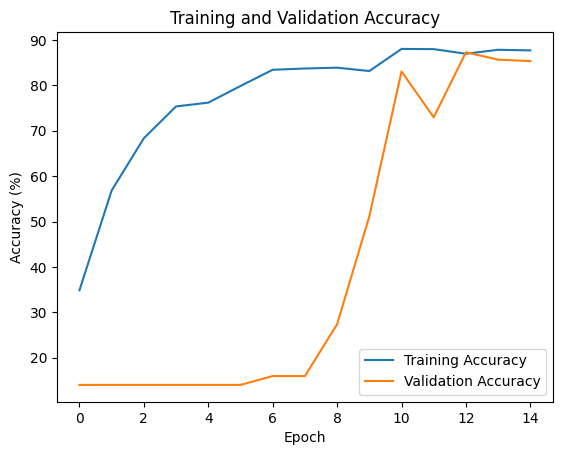

In [ ]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(valid_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

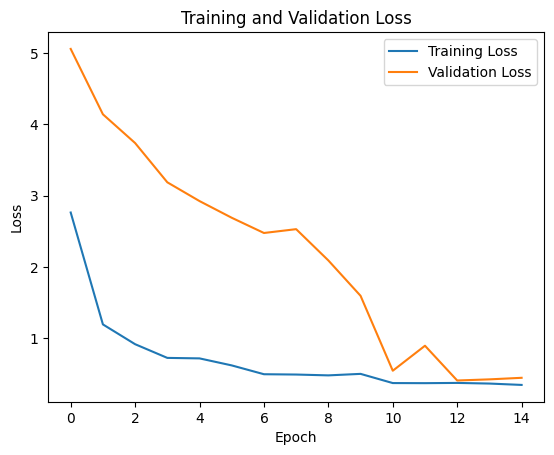

In [ ]:
# Plot training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Generate classification report for training data
train_classification_report = classification_report(true_labels_train, predicted_labels_train, zero_division=0)

# Print training classification report
print("Training Classification Report:")
print(train_classification_report)

Training Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       314
           1       0.85      0.87      0.86       306
           2       0.87      0.88      0.87       152
           3       0.84      0.89      0.87       292
           4       0.90      0.88      0.89       447
           5       0.89      0.86      0.87       189
           6       0.91      0.90      0.90       153
           7       0.91      0.89      0.90       302

    accuracy                           0.88      2155
   macro avg       0.88      0.88      0.88      2155
weighted avg       0.88      0.88      0.88      2155



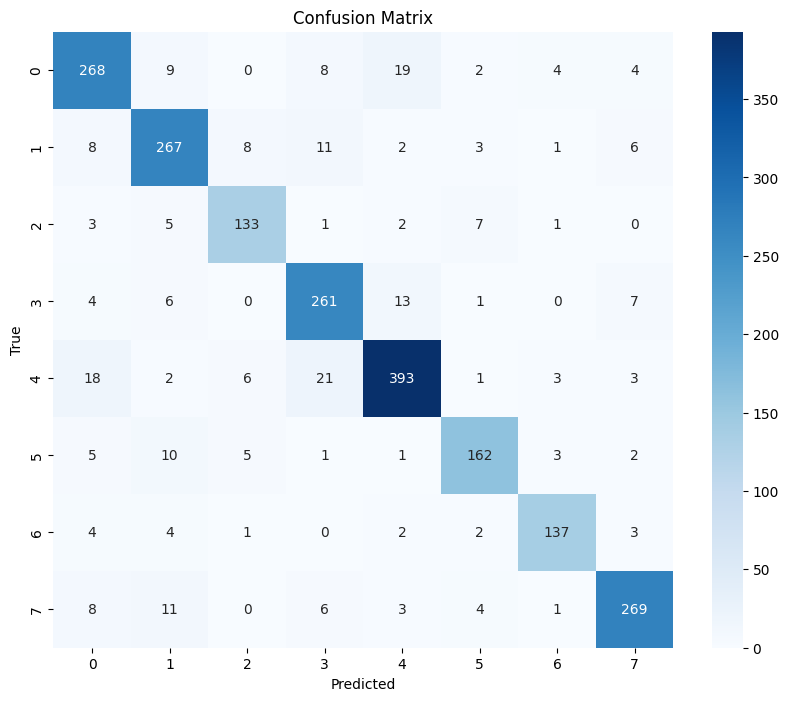

In [ ]:
# Generate confusion matrix for training data
train_confusion_matrix = confusion_matrix(true_labels_train, predicted_labels_train)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Generate classification report for validation data
valid_classification_report = classification_report(true_labels_valid, predicted_labels_valid, zero_division=0)

# Print validation classification report
print("Validation Classification Report:")
print(valid_classification_report)

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84        43
           1       0.95      0.89      0.92        45
           2       0.66      0.95      0.78        20
           3       0.86      0.84      0.85        43
           4       0.97      0.69      0.81        55
           5       0.78      0.95      0.86        22
           6       0.88      0.91      0.90        33
           7       0.80      0.93      0.86        46

    accuracy                           0.85       307
   macro avg       0.85      0.87      0.85       307
weighted avg       0.87      0.85      0.85       307



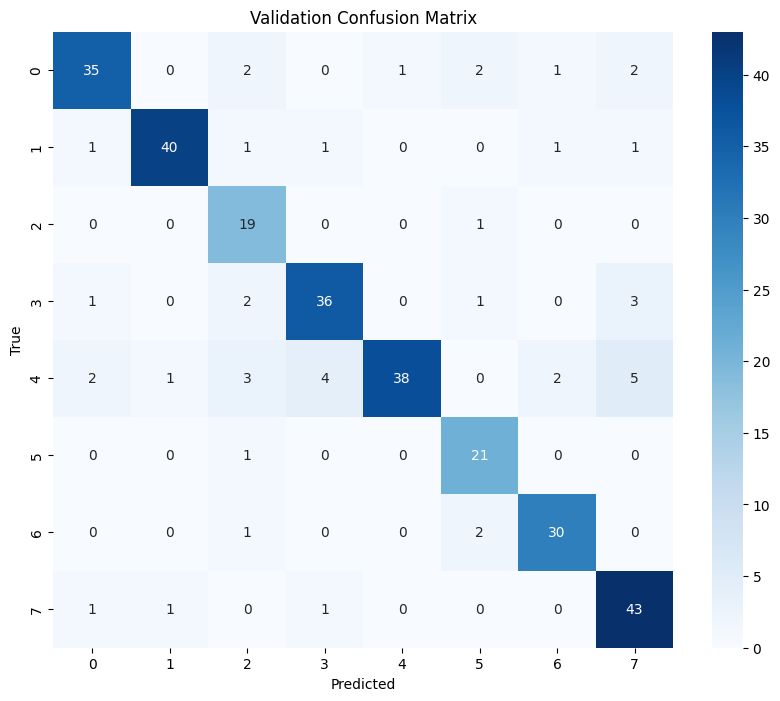

In [ ]:
# Generate confusion matrix for validation data
valid_confusion_matrix = confusion_matrix(true_labels_valid, predicted_labels_valid)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(valid_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/Concordia University/Winter 2024/Applied Artificial Intelligence/Project/Saved Models/mobilenet_model_2.pth")

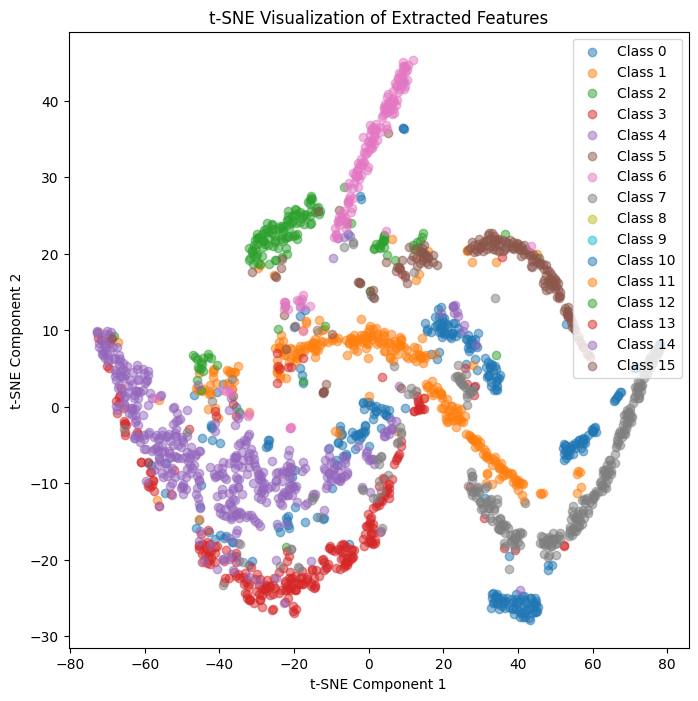

In [ ]:
# Extract features from the trained model for the training dataset
train_features = []
train_labels = []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        train_features.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Convert train_features to a numpy array
train_features = np.array(train_features)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(len(train_dataset.dataset.classes)):
    plt.scatter(train_features_tsne[np.array(train_labels) == class_idx, 0],
                train_features_tsne[np.array(train_labels) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [ ]:
# Initialize lists to store true and predicted labels for the test set
true_labels_test = []
predicted_labels_test = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels_test.extend(labels.tolist())
        predicted_labels_test.extend(predicted.tolist())

# Calculate the accuracy on the test set
accuracy = accuracy_score(true_labels_test, predicted_labels_test)
print(f"Testing Accuracy: {accuracy}")

Testing Accuracy: 0.8703403565640194


In [ ]:
# Generate classification report for test data
test_classification_report = classification_report(true_labels_test, predicted_labels_test, zero_division=0)

# Print test classification report
print("Test Classification Report:")
print(test_classification_report)

Test Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        76
           1       0.95      0.88      0.91       101
           2       0.80      0.80      0.80        51
           3       0.92      0.90      0.91        84
           4       0.91      0.84      0.88       122
           5       0.72      0.91      0.81        46
           6       0.75      0.90      0.82        50
           7       0.87      0.93      0.90        87

    accuracy                           0.87       617
   macro avg       0.86      0.87      0.86       617
weighted avg       0.88      0.87      0.87       617



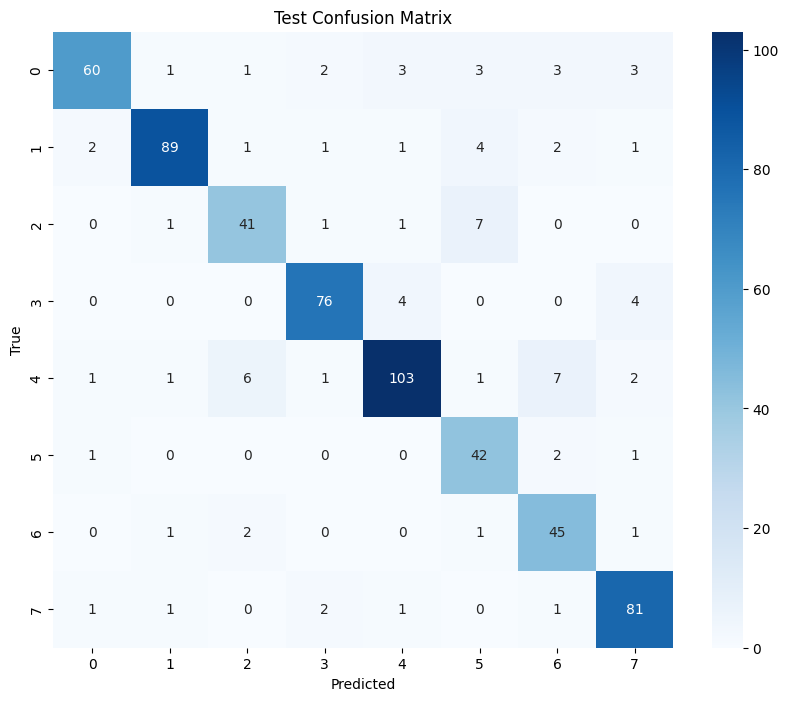

In [ ]:
# Generate confusion matrix for test data
test_confusion_matrix = confusion_matrix(true_labels_test, predicted_labels_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()